In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic.visualizations import plot_time_series, plot_map
from pathlib import Path
from functions import point_data_2_climate_grid

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import percentileofscore
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import math
import os
from scipy.spatial import cKDTree
import xoak
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)

In [2]:
start_date = "2019-07-25 00:00:00"
end_date = "2019-07-25 23:59:59" 
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/"

In [3]:
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/"
wow_file = ucl_dir + "wow_qc_BE.csv"
orig_data = pd.read_csv(wow_file)
orig_data = orig_data.loc[np.where(orig_data.m4)]
obs_data = orig_data[["p_id", "lon", "lat", "time", "ta"]]
obs_data = obs_data.rename(columns = {"ta" : "T2"})
obs_data["code"] = obs_data["lat"].astype(str) + '-' + obs_data["lon"].astype(str)

file_wrf = ucl_dir + "geo_em.d03_new.nc"
ds = xr.open_mfdataset(file_wrf, combine='by_coords')
ds = ds.assign_coords({"lat":ds.CLAT})
ds = ds.assign_coords({"lon":ds.CLONG})


#single_day_index = [i for i in np.arange(0, len(obs_data.time)) if len(obs_data.loc[i, "time"]) == 10]
#obs_data = obs_data.drop(single_day_index).reset_index(drop = True)

# Averaging stations that fall within same gridcell
[obs_data_agg, obs_indices] = point_data_2_climate_grid(obs_data, ds, 'T2')

# Converting format
obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date
obs_data = obs_data_agg.rename(columns = {"grid_index": "code"})
obs_data['time'] = pd.to_datetime(obs_data["time"])
obs_data["T2"] = obs_data["T2"]+273.15
obs_data['date'] = pd.to_datetime(obs_data['time']).dt.date
obs_data["lat"] = np.round(obs_data.lat, 6)
obs_data["lon"] = np.round(obs_data.lon, 6)
obs_data["hour"] = pd.to_datetime(obs_data['time']).dt.hour

full_range = pd.date_range(start=start_date, 
                           end=end_date, 
                           freq="h")  # Hourly intervals
drop_stations = []
for c in np.unique(obs_data.code):
    code_temp = obs_data.loc[np.where(obs_data.code == c)].reset_index(drop = True)
    missing_hours = full_range.difference(code_temp["time"])
    if len(missing_hours) > 0:
        drop_stations.append(c)
#print("In " + obs_data_str + str(len(drop_stations)) " are removed.")

drop_indices = [i for i in np.arange(0, len(obs_data)) if obs_data.loc[i, "code"] in drop_stations]
obs_data = obs_data.drop(drop_indices).reset_index(drop = True)

/tmp/ipykernel_351310/673543245.py:22: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date


In [4]:
obs_indices

,lat,lon,grid_index
0,50.198403,4.993511,30652
1,50.296906,4.555106,33537
2,50.350400,4.265500,35136
3,50.429881,3.772184,37045
4,50.524698,4.151470,40959
...,...,...,...
99,51.232722,3.768319,65876
100,51.256376,5.484762,69234
101,51.259000,4.680800,67883
102,51.280500,4.420800,68513


In [5]:
d_coord_points = obs_data[["lat", "lon", "code"]]
d_coord_points = d_coord_points.drop_duplicates().reset_index(drop = True)
#d_coord_points.to_csv(ucl_dir + 'WOW_data_locations.csv')

In [6]:
d_coord_points

,lat,lon,code
0,50.354847,4.265076,35136
1,50.426495,3.773651,37045
2,50.522190,4.152130,40959
3,50.640697,3.290985,44138
4,50.638233,3.376526,44144
...,...,...,...
56,51.190937,4.907532,65955
57,51.186817,5.211120,66300
58,51.190247,5.530152,66970
59,51.282860,4.424316,68513


In [7]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [8]:
def plot_points_map(d_coord_points, region, bounds, scale_var=None, lat_name = "lat", lon_name = "lon", station_id = "code", add_labels = False): 
    """
    Plots a map with points and an optional colorbar.
    
    Parameters:
    - d_coord_points (pd.DataFrame): DataFrame containing 'lon', 'lat', 'code', and optionally scale_var.
    - region (str): The region to display.
    - bounds (dict): Dictionary containing lat/lon bounds for regions.
    - scale_var (str, optional): Column name for variable used to scale colors.
    """
    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Handle scaling variable
    if scale_var:
        cmap = plt.cm.Reds
        norm = Normalize(vmin=d_coord_points[scale_var].min(), vmax=d_coord_points[scale_var].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create a ScalarMappable for the colorbar
        sm.set_array([])  # ScalarMappable requires a linked array but it won't be used here

    # Plot each point and add a label
    for i in np.arange(0, len(d_coord_points)):
        lon = d_coord_points.loc[i, lon_name]
        lat = d_coord_points.loc[i, lat_name]
        key = d_coord_points.loc[i, station_id]

        if scale_var:
            var_value = d_coord_points.loc[i, scale_var]
            code_color = cmap(norm(var_value))
            ax.scatter(lon, lat, edgecolor='black', s=50, c=[code_color], transform=ccrs.PlateCarree())
        else:
            ax.scatter(lon, lat, color='red', s=50, transform=ccrs.PlateCarree())
        
        # Add text labels
        if add_labels:
            ax.text(lon + 0.05, lat - 0.05, key, transform=ccrs.PlateCarree())


    # Set extent based on bounds
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    # Add colorbar if scale_var is provided
    if scale_var:
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
        cbar.set_label(f'{scale_var.capitalize()}')

    # Add a title
    ax.set_title('Location of Points', loc='right')

    # Show the plot
    plt.show()

    return ax


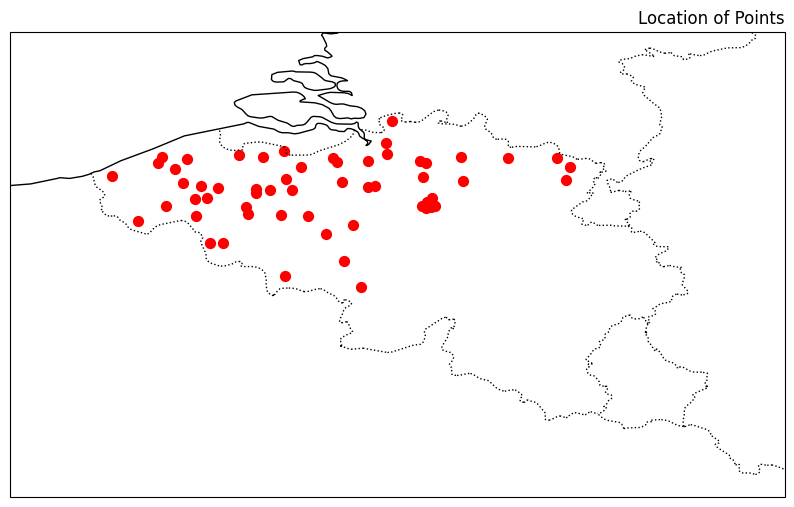

<GeoAxes: title={'right': 'Location of Points'}>

In [9]:
plot_points_map(d_coord_points, "belgium", bounds, station_id = "code")

## Visualizing loss of observations

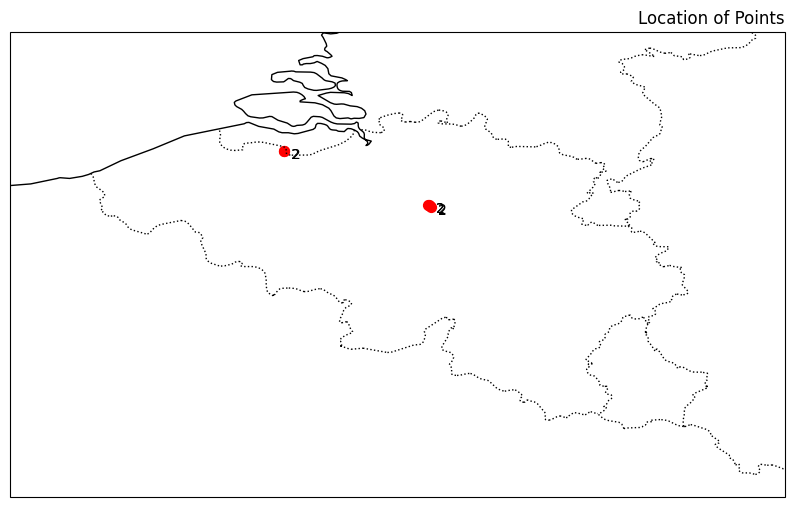

In [10]:
df_duplicates = pd.DataFrame([], columns = ["lat", "lon", "grid_index", "count"])
for ind in np.unique(obs_indices.grid_index):
    locs = np.where(obs_indices.grid_index == ind)[0]
    if len(locs) > 1:
        for i in locs:
            df_duplicates.loc[i, ["lat", "lon", "grid_index"]] = obs_indices.loc[i]
            df_duplicates.loc[i, "count"] = len(locs)

df_duplicates = df_duplicates.reset_index(drop = True)
ax2 = plot_points_map(df_duplicates, "belgium", bounds, station_id = "count", add_labels=True)

### Adding LCZ info

In [11]:
d_coord_points

,lat,lon,code
0,50.354847,4.265076,35136
1,50.426495,3.773651,37045
2,50.522190,4.152130,40959
3,50.640697,3.290985,44138
4,50.638233,3.376526,44144
...,...,...,...
56,51.190937,4.907532,65955
57,51.186817,5.211120,66300
58,51.190247,5.530152,66970
59,51.282860,4.424316,68513


In [12]:
file_wrf = ucl_dir + "geo_em.d03_LCZ_params.nc"
ds = xr.open_mfdataset(file_wrf, combine='by_coords')
ds = ds.assign_coords({"lat":ds.CLAT})
ds = ds.assign_coords({"lon":ds.CLONG})
da = ds["LU_INDEX"]
da.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
#d_coord_points = obs_data[["code", "lat", "lon"]]
#d_coord_points = d_coord_points.drop_duplicates().reset_index(drop = True)
for i in np.arange(0, len(d_coord_points)):
    point_coord = d_coord_points.loc[i]    
    lat_array = xr.DataArray(np.array([point_coord.lat]), dims='point')
    lon_array = xr.DataArray(np.array([point_coord.lon]), dims='point')
    d_coord_points.loc[i, "LU_INDEX"] = da.xoak.sel(lat = lat_array, lon = lon_array).values

In [13]:
indx_urb = np.where(d_coord_points["LU_INDEX"] >= 50)[0]
indx_rur = np.where(d_coord_points["LU_INDEX"] < 50)[0]
urb_loc = d_coord_points.loc[indx_urb].reset_index(drop = True)
rur_loc = d_coord_points.loc[indx_rur].reset_index(drop = True)


In [14]:
rur_loc

,lat,lon,code,LU_INDEX
0,50.354847,4.265076,35136,12.0
1,50.426495,3.773651,37045,12.0
2,50.522190,4.152130,40959,12.0
3,50.779823,2.828064,48641,12.0
4,50.755592,4.216126,49386,12.0
5,50.823826,3.533569,50958,12.0
6,50.817062,3.748230,50973,12.0
7,50.811363,3.919922,50985,14.0
8,50.874981,3.006195,52217,12.0
9,50.869461,3.522705,52577,12.0


In [15]:
urb_loc

,lat,lon,code,LU_INDEX
0,50.640697,3.290985,44138,56.0
1,50.638233,3.376526,44144,56.0
2,50.698460,4.039154,47106,56.0
3,50.815338,3.203064,50287,58.0
4,50.864441,4.685882,53954,56.0
5,50.924248,3.196258,54174,56.0
6,50.872314,4.715424,54280,53.0
7,50.881931,4.702026,54603,53.0
8,50.880760,4.730682,54605,56.0
9,50.880177,4.744995,54606,56.0


In [16]:
urb_loc.to_csv(ucl_dir + 'Location_qc_' + "urban_" + "wow" + ".csv", index = False)
rur_loc.to_csv(ucl_dir + 'Location_qc_' +  "rural_" + "wow" +".csv", index = False)
d_coord_points.to_csv(ucl_dir + "Location_qc_lcz_wow.csv", index = False)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


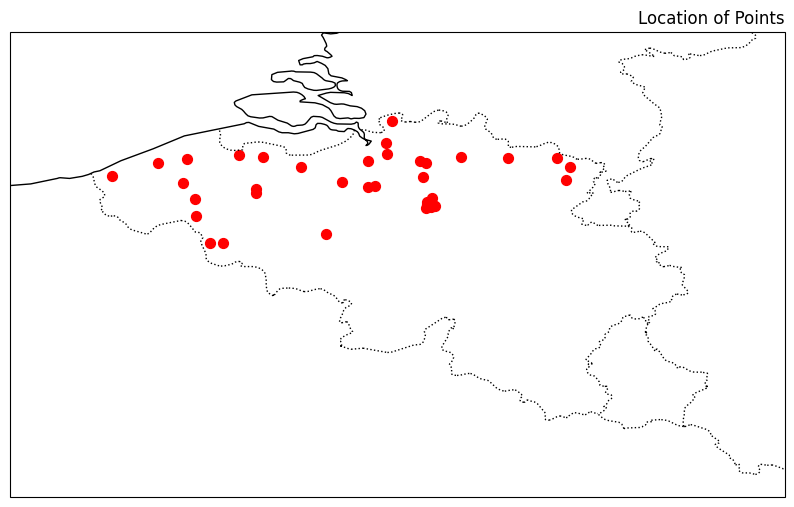

In [17]:
ax2 = plot_points_map(urb_loc, "belgium", bounds, station_id = "code")

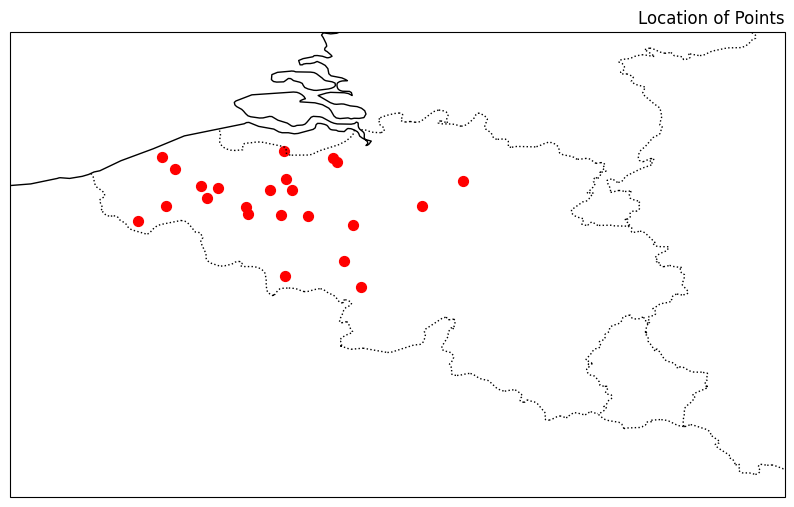

In [18]:
ax2 = plot_points_map(rur_loc, "belgium", bounds, station_id = "code")